# Tutorial for SimSiam Implementation
SimSiam is a self-supervised learning method used for learning feature representations without requiring labeled data. It leverages contrastive learning by maximizing the similarity between two different augmented views of the same image. This tutorial walks through the provided SimSiam implementation.

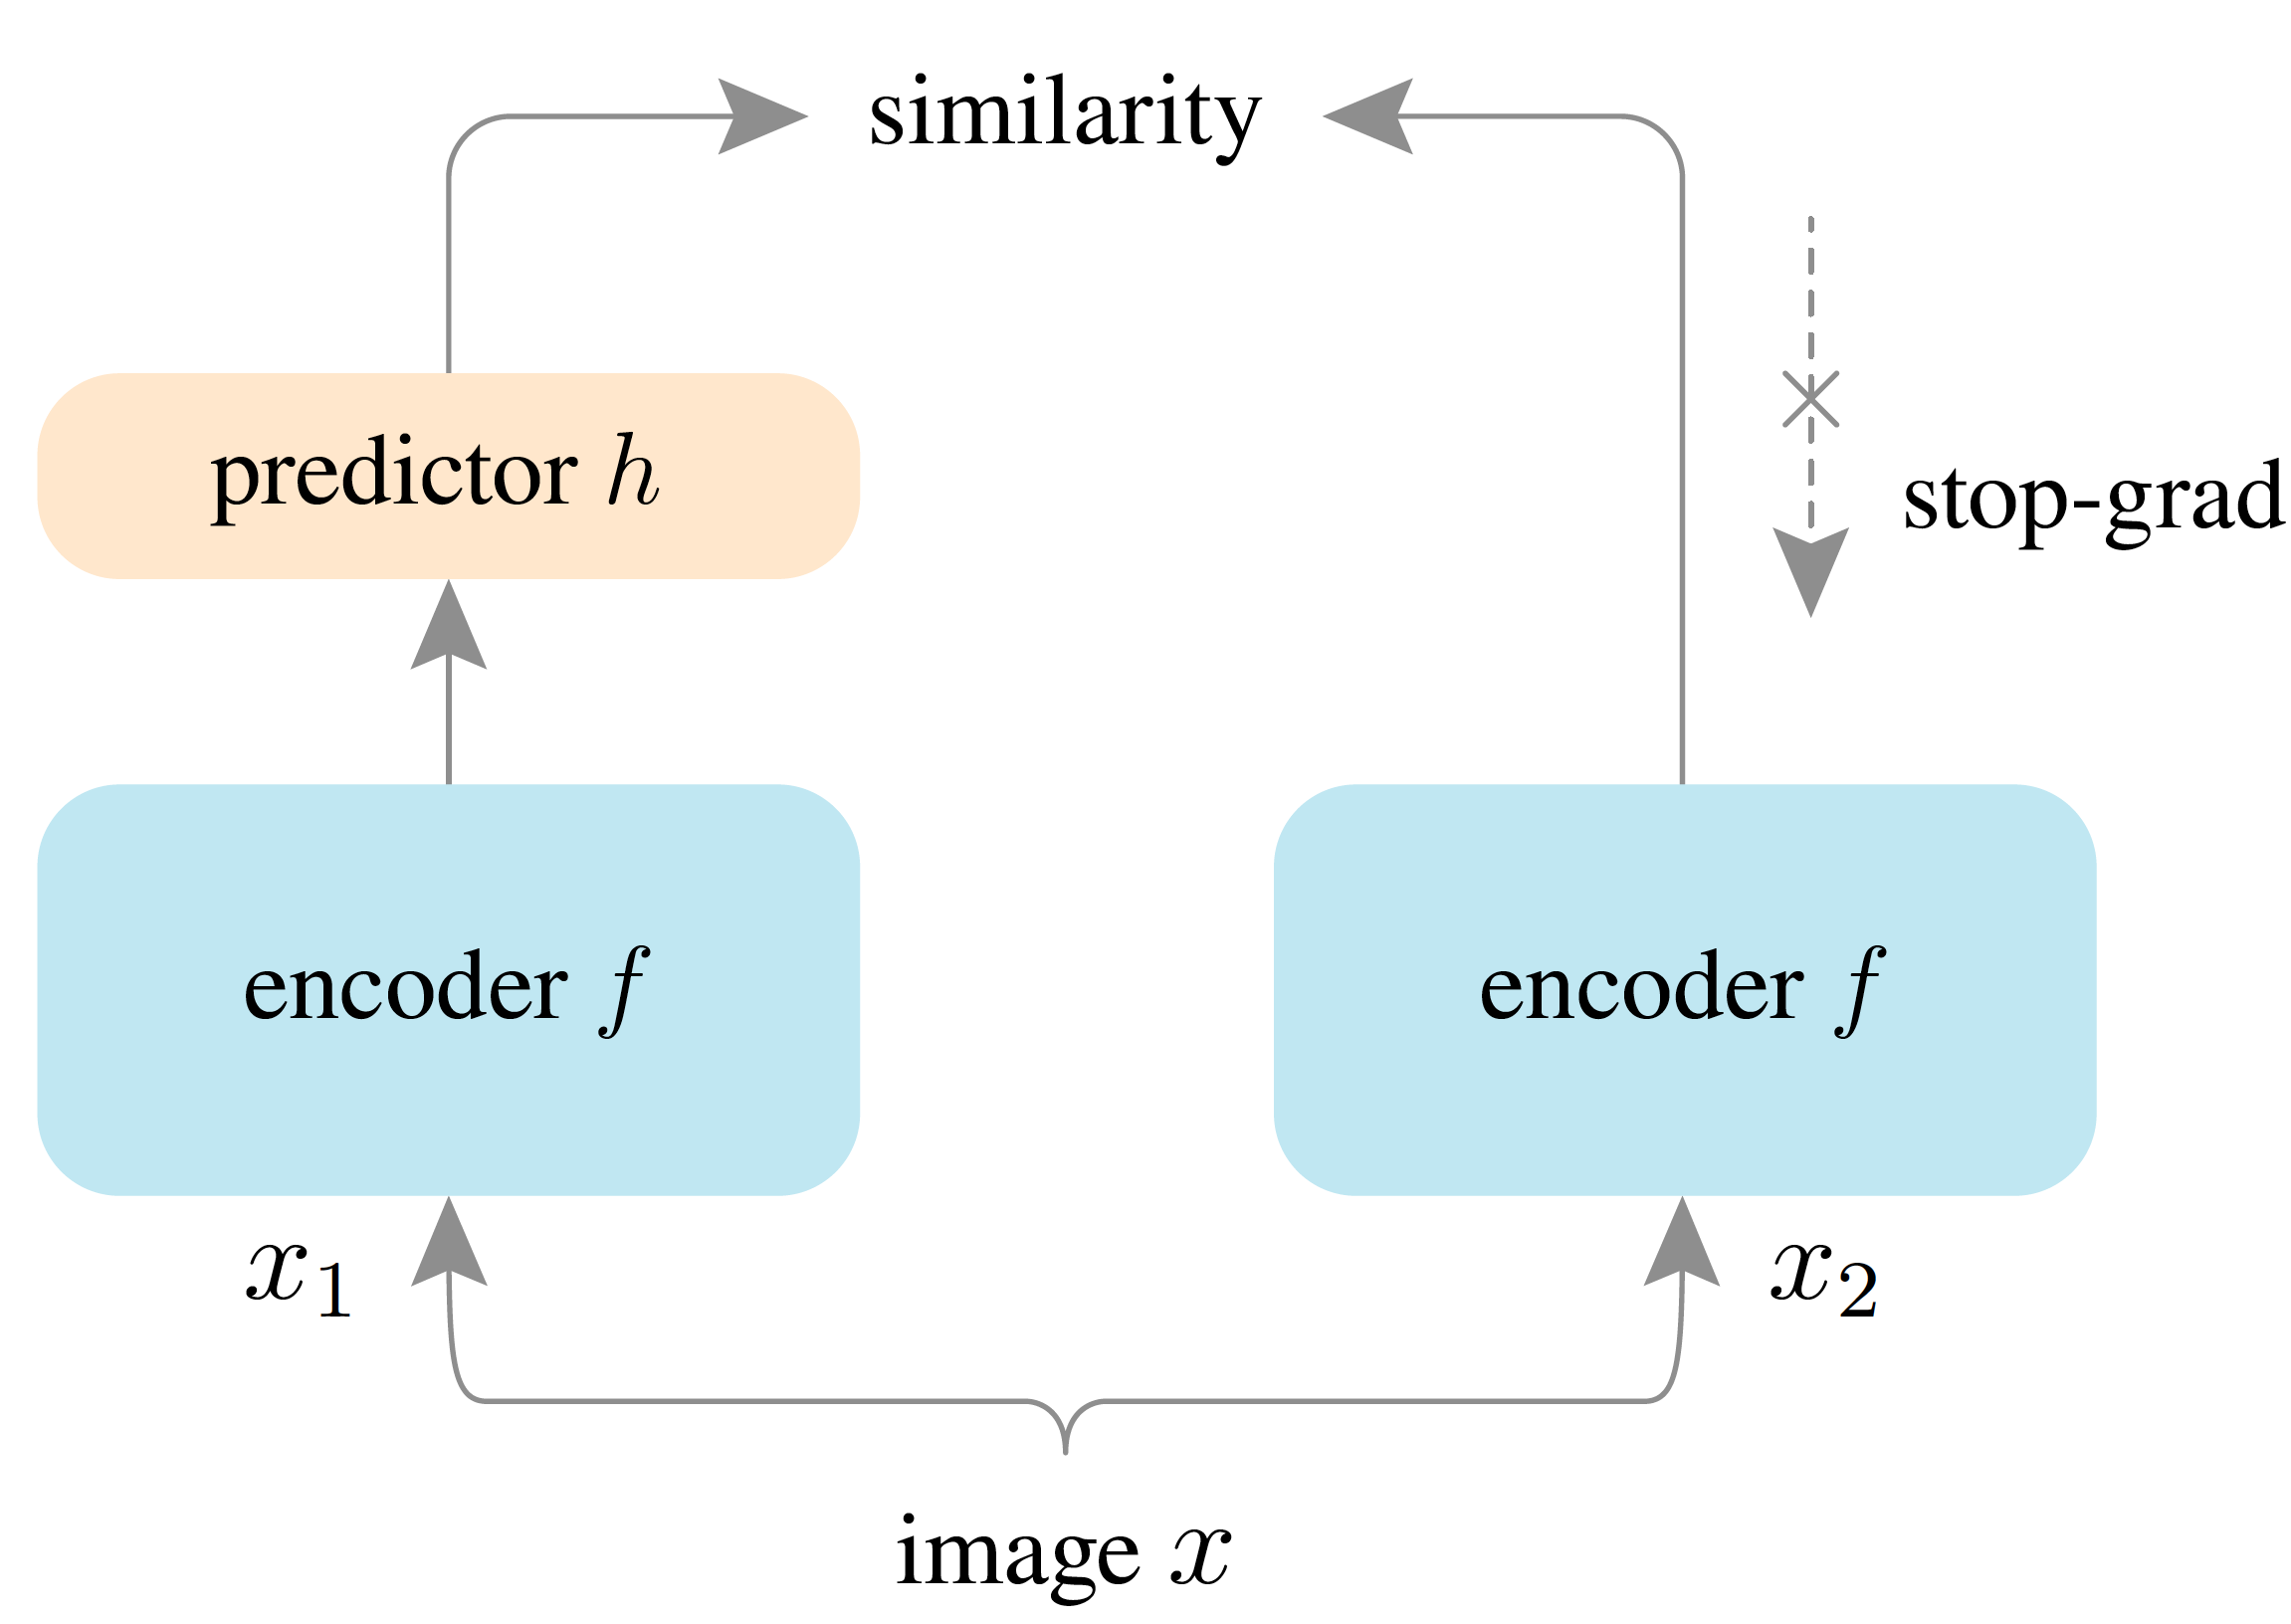

## Overview of the Architecture
The SimSiam model has the following components:

Base Encoder: A backbone model (e.g., ResNet) that encodes input images into feature vectors.

Projector: A 3-layer MLP that maps encoder outputs to a space where contrastive learning is applied.

Predictor: A 2-layer MLP that predicts one view's feature representation from the other.

Key features:

Stop Gradient: Gradients are stopped for the target embeddings to avoid trivial solutions.

Multiple MLP Modes: Configurable predictor behavior to experiment with various setups.

## Using SimSiam with a Sample Dataset
We'll use the CIFAR-10 dataset as an example. SimSiam benefits from strong data augmentations to generate diverse views of the same image, so we’ll include augmentations like random cropping, flipping, and color jittering.

# Dataset and Augmentation Setup

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Define SimSiam augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),  # Random crop
    transforms.RandomHorizontalFlip(p=0.5),             # Horizontal flip
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),          # Color jitter
    transforms.RandomGrayscale(p=0.2),                  # Grayscale
    transforms.ToTensor(),                              # Convert to tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # Normalize
])

# Load CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    transform=None,  # No transformations applied here
    download=True
)

# DataLoader for batch loading
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)


100%|██████████| 170M/170M [00:02<00:00, 78.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Custom Augmentation Dataset for SimSiam
Since SimSiam requires two augmented views of the same image, we need a custom dataset wrapper:

In [3]:
class SimSiamDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Get image and ignore label
        view1 = self.transform(img)  # First augmented view
        view2 = self.transform(img)  # Second augmented view
        return view1, view2

# Wrap CIFAR-10 dataset
simsiam_dataset = SimSiamDataset(train_dataset, train_transform)

# DataLoader
simsiam_loader = DataLoader(simsiam_dataset, batch_size=128, shuffle=True, num_workers=4)



# Training SimSiam with CIFAR-10
Below is a training loop using the dataset and DataLoader.

In [4]:
from torchvision.models import resnet18
import torch.optim as optim
from simsiam import SimSiam

# Define SimSiam model with ResNet-18
simsiam_model = SimSiam(
    base_encoder=resnet18,  # Using ResNet-18 as the backbone
    dim=2048,              # Feature dimension
    pred_dim=512,          # Predictor hidden dimension
    stop_gradient=True,    # Stop gradient on targets
)

# Move model to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
simsiam_model = simsiam_model.to(device)

# Optimizer
optimizer = optim.SGD(simsiam_model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)

# Training loop
epochs = 10
for epoch in range(epochs):
    epoch_loss = 0.0
    simsiam_model.train()

    for view1, view2 in simsiam_loader:
        # Move data to GPU
        view1, view2 = view1.to(device), view2.to(device)

        # Forward pass
        p1, p2, z1, z2 = simsiam_model(view1, view2)

        # Compute SimSiam loss
        loss = simsiam_model.loss(p1, p2, z1, z2)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for logging
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(simsiam_loader):.4f}")


Epoch 1/10, Loss: -0.1604
Epoch 2/10, Loss: -0.2007
Epoch 3/10, Loss: -0.2085
Epoch 4/10, Loss: -0.2085
Epoch 5/10, Loss: -0.2097
Epoch 6/10, Loss: -0.2115
Epoch 7/10, Loss: -0.2130
Epoch 8/10, Loss: -0.2164
Epoch 9/10, Loss: -0.2136
Epoch 10/10, Loss: -0.2168


# Visualizing Feature Embeddings with t-SNE
To analyze the quality of the learned representations, we can use t-SNE to project high-dimensional features into 2D space for visualization.

Visualize Embeddings
Here we extract features from the SimSiam encoder and visualize them:

Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


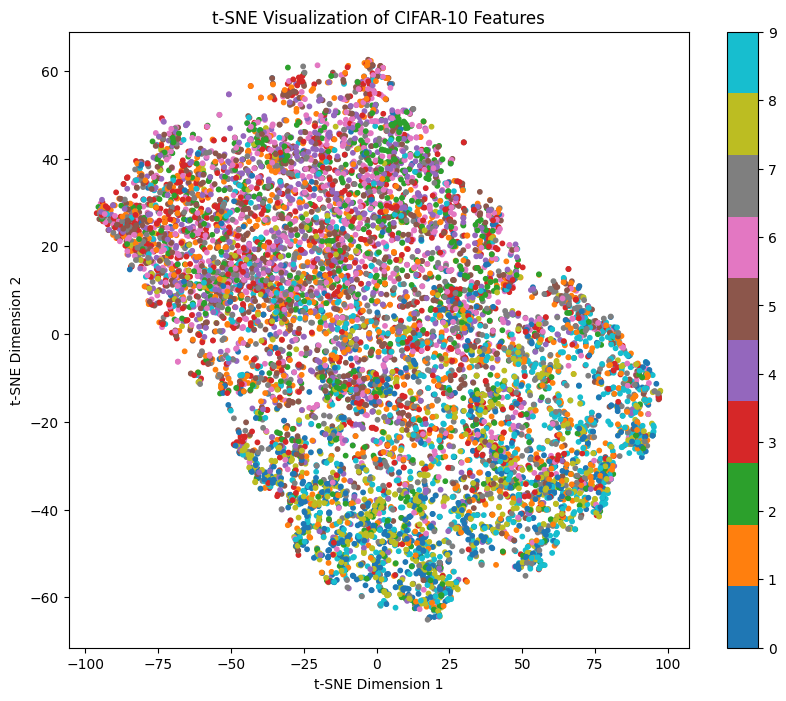

In [6]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Extract features from test data using the trained encoder
def extract_features(encoder, dataloader, device):
    features, labels = [], []
    encoder.eval()
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            feature = encoder(images)
            features.append(feature.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Get features and labels from the test set
test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]),
    download=True,
)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Extract features using the SimSiam encoder
features, labels = extract_features(simsiam_model.encoder, test_loader, device)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE Visualization of CIFAR-10 Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


# Evaluate Learned Representations
After pretraining with SimSiam, the encoder can be evaluated by fine-tuning on a supervised task like classification.

Fine-Tune on CIFAR-10 Classification:

In [7]:
# Replace the projector head with a classification head
simsiam_model.encoder.fc = torch.nn.Linear(simsiam_model.encoder.fc[0].in_features, 10)

# Move model back to GPU if necessary
simsiam_model = simsiam_model.to(device)

# Define classification optimizer and criterion
optimizer = optim.SGD(simsiam_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Load labeled CIFAR-10 dataset
classification_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]),
    download=False
)
classification_loader = DataLoader(classification_dataset, batch_size=128, shuffle=True, num_workers=4)

# Training loop for classification
for epoch in range(10):
    epoch_loss = 0.0
    correct = 0
    total = 0
    simsiam_model.train()

    for images, labels in classification_loader:
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = simsiam_model.encoder(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/10, Loss: {epoch_loss/len(classification_loader):.4f}, Accuracy: {100. * correct / total:.2f}%")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10, Loss: 1.9380, Accuracy: 27.84%
Epoch 2/10, Loss: 1.3965, Accuracy: 48.63%
Epoch 3/10, Loss: 1.1253, Accuracy: 59.22%
Epoch 4/10, Loss: 0.9457, Accuracy: 66.31%
Epoch 5/10, Loss: 0.8109, Accuracy: 71.11%
Epoch 6/10, Loss: 0.6975, Accuracy: 75.37%
Epoch 7/10, Loss: 0.5953, Accuracy: 79.09%
Epoch 8/10, Loss: 0.5015, Accuracy: 82.25%
Epoch 9/10, Loss: 0.4146, Accuracy: 85.26%
Epoch 10/10, Loss: 0.3385, Accuracy: 88.08%


# Conclusions and Next Steps
Summary:
High Accuracy but Overlapping Clusters:

We successfully demonstrated how to use the SimSiam model for feature learning and evaluated the quality of its learned representations.

While the encoder's learned features are effective for classification, their structure in the embedding space is not perfectly ideal for visualization. This is a common observation in self-supervised learning.


Improvement Ideas:
To achieve better results, consider training the model with the following optimized hyperparameters and strategies:

In [ ]:
epochs = 1000

batch_size = 1024

#Simsiam params
dim=2048
pred_dim=512

# optimizer
lr = 0.03
momentum = 0.9
weight_decay = 0.0005